`Julian Rippert - MIDS Spring 2023`

In [5]:
# standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
np.set_printoptions(suppress=True)
pd.options.display.float_format = "{:,.6f}".format

#import operator

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# pipelines
from sklearn.pipeline import _name_estimators
from sklearn.pipeline import Pipeline

# data preprocessing, cross-validation, accuracies
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# individual classifiers
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 

# ensemble classifiers
##(not that we use a user defined class for MajorityVoting)
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Tree Visualisation
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# others
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA

#need this as we have a lot of columns
pd.options.display.max_rows = 1000

#hide warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Motivation

This data set stems from the __[American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/data)__ data set on kaggle.

The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

 the following features being categorical:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


**Why do we care?** - Default events are financially unfavorable for banks and card issuers since they will not be able to recoup the monies lent out to consumers through credit. Banks may use such default prediction models to monitor its current card-holder base and proactively work with consumers to avoid default actions. Banks may also use such default prediction models to help decide whether or not to issue credit to potential new customers.

___

## Miscellaneous

In [6]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

___

## Loading in the Data

read the data from @munumbutt's __[AMEX-Feather-Dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather)__ In this Feather file, the floating point precision has been reduced from 64 bit to 16 bit

In [7]:
%%time 
df = pd.read_feather('train_data.ftr')

CPU times: user 3.4 s, sys: 6.64 s, total: 10 s
Wall time: 2.3 s


`Lets take a look at the data`

In [8]:
display(df.head(2))
#df.value_counts()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0


Since it is a time series dataset, we have to sort it by the date or S_2 feature, then will seperate into the train and test split.

In [9]:
df = df.sort_values(by ='S_2')

In [10]:
min(df['S_2'])

Timestamp('2017-03-01 00:00:00')

In [11]:
max(df['S_2'])

Timestamp('2018-03-31 00:00:00')

___

## Exploratory Data Analysis

From the describe below we can confirm that the data is already normalized which was mentioned in the kaggle prompt. Mean data is mostly nan since many columns have nans, we will deal with these later one

For EDA purposes we will take a sample of the dataframe given its size

In [12]:
eda_df = df.sample(frac=0.35)

In [13]:
eda_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
P_2,"1,919,869.000000",NaN,0.000000,-0.442627,0.480469,0.694824,0.865234,1.009766
D_39,"1,936,008.000000",NaN,0.000000,0.000000,0.004528,0.009056,0.236450,5.359375
B_1,"1,936,008.000000",NaN,0.000000,-7.589844,0.008850,0.031219,0.125610,1.324219
B_2,"1,935,313.000000",NaN,0.000000,0.000000,0.105591,0.814453,1.001953,1.009766
R_1,"1,936,008.000000",NaN,0.000000,0.000000,0.002895,0.005779,0.008667,3.255859
S_3,"1,577,949.000000",NaN,0.000000,-0.544922,0.127319,0.163940,0.257812,4.945312
D_41,"1,935,313.000000",NaN,0.000000,0.000000,0.002871,0.005745,0.008614,7.511719
B_3,"1,935,313.000000",NaN,0.000000,0.000000,0.005222,0.009773,0.154907,1.573242
D_42,"277,227.000000",0.000000,0.000000,-0.000454,0.037598,0.120117,0.250488,4.191406
D_43,"1,355,078.000000",NaN,0.000000,0.000000,0.042206,0.088440,0.184326,10.109375


In [14]:
categoricals = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for i in categoricals:
    print(eda_df[i].value_counts())

0.0    1648928
1.0     267346
2.0      19039
Name: B_30, dtype: int64
2.0    683904
3.0    439201
1.0    406325
5.0    155123
4.0    103348
7.0     90999
6.0     56413
Name: B_38, dtype: int64
1.0    1160909
0.0     713122
Name: D_114, dtype: int64
0.0    1871739
1.0       2292
Name: D_116, dtype: int64
-1.0    508341
3.0     409034
4.0     398248
2.0     233658
5.0     160720
6.0     121093
1.0      42937
Name: D_117, dtype: int64
0.0    1655256
1.0     218775
Name: D_120, dtype: int64
1.0     1492022
0.0      311857
-1.0      91151
Name: D_126, dtype: int64
CO    1441761
CR     325976
CL     153132
XZ       8983
XM       3710
XL       2446
Name: D_63, dtype: int64
O     1020745
U      532409
R      293625
        76248
-1      12981
Name: D_64, dtype: int64
1.0    216171
0.0      2188
Name: D_66, dtype: int64
6.0    974985
5.0    419669
3.0    169252
4.0    167130
2.0     77045
1.0     46398
0.0      5620
Name: D_68, dtype: int64


Most categoricals look ok however, I will have to make the following adjustments: 
* B_38, reindex to start index 0 
* D_117,D_126,D_64 Drop since it includes negative, kaggle provides no info on what that means
* D_63, needs to be one hot encoded

Text(0, 0.5, 'Sample Number')

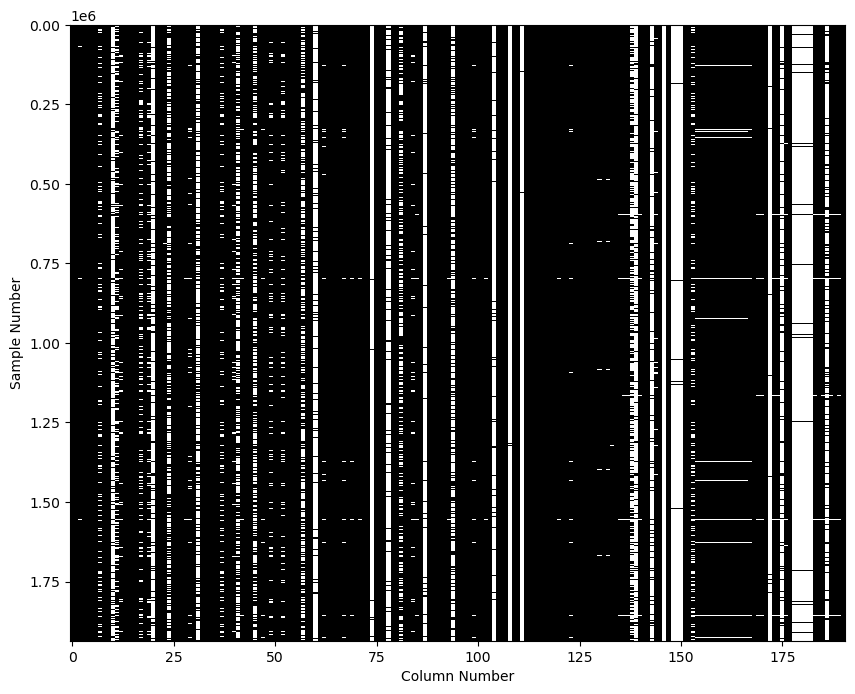

In [15]:
#Visually inspect Nans
plt.figure(figsize=(10, 8))
plt.imshow(eda_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

As we can see, some columns seems to be have very high amounts of NaNs, lets find the columns to drop according to a 40% threshold below

In [16]:
del_cols = eda_df.isna().sum()/eda_df.shape[0]
print("Length before filtering out high Nan count cols: ",del_cols.size)
del_cols = del_cols.reset_index() 
del_cols.columns = ["Features","Percent_nans"]
del_cols = del_cols[del_cols.Percent_nans > 0.4]
print("Number of columns to drop: ",del_cols.size)


Length before filtering out high Nan count cols:  191
Number of columns to drop:  62


In [17]:
del_cols.Features.values

array(['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66',
       'D_73', 'D_76', 'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88',
       'D_105', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39',
       'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138',
       'D_142'], dtype=object)

Per the above we will drop all columns which are more than 40% NaNs. At some point the mean imputing will be futile.

Cols to delete = ['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66',
       'D_73', 'D_76', 'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88',
       'D_105', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39',
       'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138',
       'D_142']

Lets look at the correlation of variables. But with a subsample of the data given the size

<timed exec>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


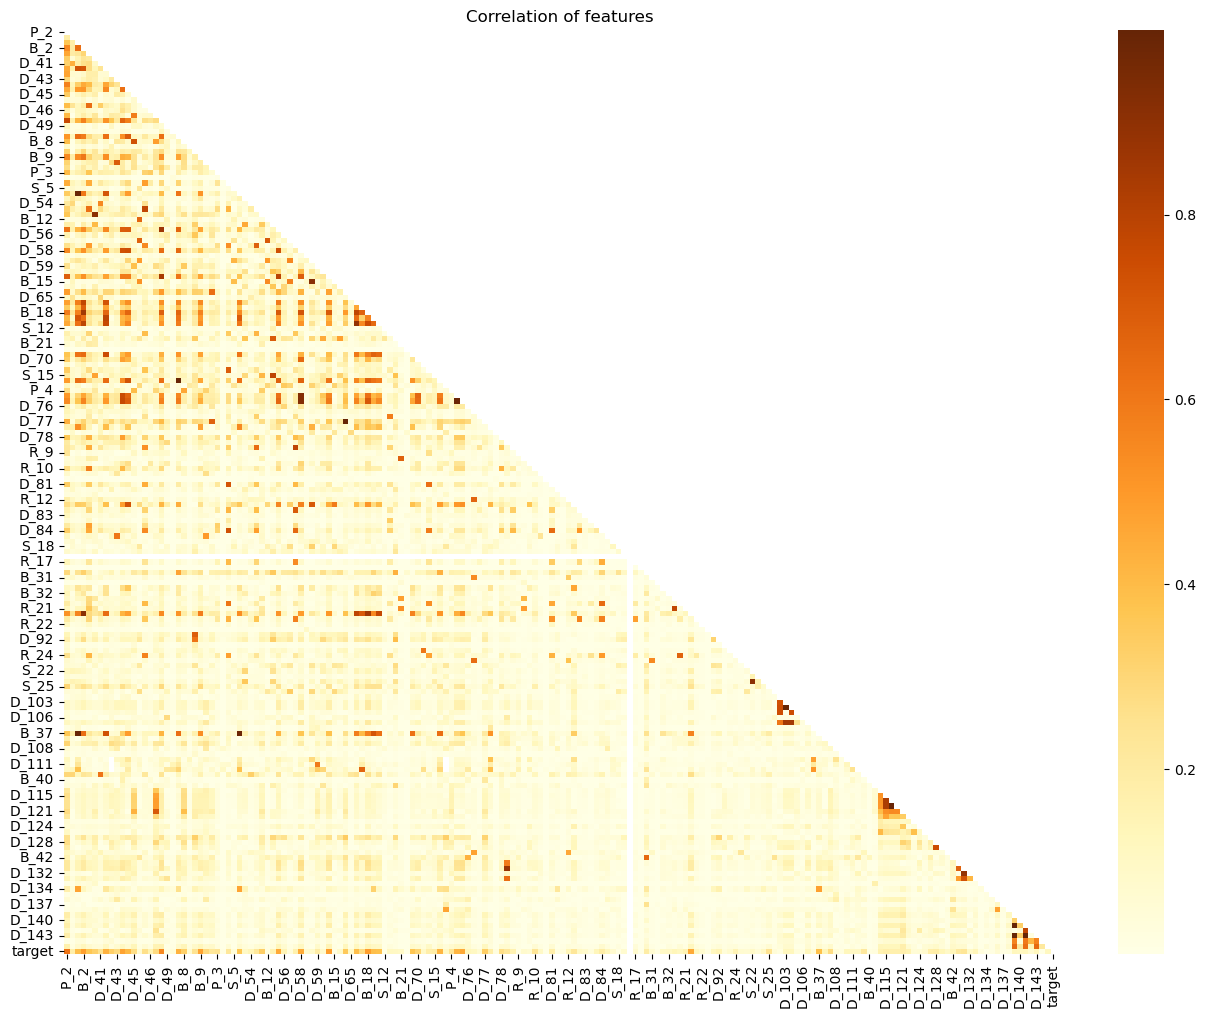

CPU times: user 26.7 s, sys: 681 ms, total: 27.4 s
Wall time: 26.9 s


In [18]:
%%time
sample_corr_df = eda_df.sample(frac=0.3, replace=False)
correlations = sample_corr_df.corr().abs()

mask=np.triu(np.ones_like(correlations))

fig, ax = plt.subplots(1,1, figsize=(16,12))
sns.heatmap(correlations, ax=ax, mask=mask, cmap='YlOrBr')
ax.set_title("Correlation of features")
plt.show()

In [19]:
#save some memory
del eda_df

___

## Pre-Processing & Feature Engineering

`Feature Engineeering`

In [20]:
#drop the ID column and date columns since it wont help out model
df.pop('customer_ID')
df.pop('S_2')

df.head(2)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
1514245,0.840332,0.385498,0.014931,0.255859,0.003902,0.148682,0.160400,0.040253,NaN,0.194092,...,NaN,NaN,0.007015,0.005955,0.000452,NaN,0.009331,0.007061,0.008537,0
1586367,0.608887,0.566895,0.037079,1.004883,0.001968,0.145142,0.006760,0.006065,NaN,0.242676,...,NaN,NaN,0.003370,0.004475,0.004517,NaN,0.007591,0.007519,0.007584,0


I need to drop the columns up from above which were predominantly NaNs
 ['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73', 'D_76', 'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']

In [21]:
del_cols = ['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73', 'D_76', 
            'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26', 'D_108',
            'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']

for i in del_cols: 
    df.pop(i)

Lets check out the new dimensions of our data:

In [22]:
df.shape

(5531451, 158)

In [23]:
cols = df.columns
#new_cols = [i for i in cols if i not in del_cols]

B_38 needs to be reindex to start index 0

In [24]:
B_38_mapping = {label: idx for idx, label in enumerate(np.unique(df['B_38']))}
df['B_38'] = df['B_38'].map(B_38_mapping)

#lets confirm it worked
df['B_38'].value_counts()

1    1953232
2    1255315
0    1160047
4     444856
3     294917
6     259028
5     162040
Name: B_38, dtype: int64

Drop the categoricals with negative values, unclear what these signify

D_117
D_126
D_64

For D_63, this column need to be one hot encoded

In [25]:
df.pop('D_117')
df.pop('D_126')
df.pop('D_64')
display(df.columns.get_loc("D_63"))

45

In [26]:
col = df.columns

In [27]:
%%time
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [45])], remainder='passthrough')
df = columnTransformer.fit_transform(df)

CPU times: user 5.73 s, sys: 8.98 s, total: 14.7 s
Wall time: 19.1 s


for all cols which we didnt drop due to our nan thresholds we will impute the mean

In [28]:
%%time 

imp=SimpleImputer(missing_values=np.NaN)
df=pd.DataFrame(imp.fit_transform(df))

CPU times: user 15.4 s, sys: 21.8 s, total: 37.3 s
Wall time: 49 s


In [29]:
#lets confirm it worked
np.array(df.isna().sum()/df.shape[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [30]:
col = list(col)
col.remove('D_63')

In [31]:
one_hot_cols = ['onehot1','onehot2','onehot3','onehot4','onehot5','onehot6']
new_cols = one_hot_cols + col

In [32]:
df.columns = new_cols
df.head(2)

,onehot1,onehot2,onehot3,onehot4,onehot5,onehot6,P_2,D_39,B_1,B_2,...,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.840332,0.385498,0.014931,0.255859,...,0.984863,0.203735,0.006176,0.007015,0.005955,0.000452,0.009331,0.007061,0.008537,0.000000
1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.608887,0.566895,0.037079,1.004883,...,0.005592,0.005657,0.001844,0.003370,0.004475,0.004517,0.007591,0.007519,0.007584,0.000000


___

## Split the Datasets

`Lets Split the dataset`

In [33]:
X = df
Y = X.pop('target')

In [34]:
#shuffle default is True, we set to false to preserve time series ordering
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)

# 0.25 x 0.8 = 0.2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,  shuffle = False) 

In [35]:
print('Training Features dimensions: ', X_train.shape)
print('Training Labels dimensions: ', Y_train.shape)
print('Validation Features dimensions: ', X_val.shape)
print('Validation Labels dimensions: ', Y_val.shape,'\n')

print('Training Percent of Positive Labels:  %.4f'%(Y_train.value_counts()[1]/Y_train.value_counts().sum()), '\n')
print('Validation Percent of Positive Labels:  %.4f'%(Y_val.value_counts()[1]/Y_val.value_counts().sum()))

Training Features dimensions:  (3318870, 159)
Training Labels dimensions:  (3318870,)
Validation Features dimensions:  (1106290, 159)
Validation Labels dimensions:  (1106290,) 

Training Percent of Positive Labels:  0.2440 

Validation Percent of Positive Labels:  0.2553


Even though we did not ensure stratification of our label across training and test dataset, we have results in a pretty even distribution of labels

The last step, to save some memory lets delete the original datasets

In [36]:
del df, X, Y

___

# Model Building

I will be implementing a **Random Forest model** which is an **ensemble** of decision tree classifiers. It is also a bagging method where deep trees (Decision Trees), fitted on bootstrap samples, are combined to produce an output with lower variance. (bootstrapping is random sampling with replacement from the available training data. Bagging is a bootstrap aggregation where we train an estimator for each bootstrapped dataset)

For each decision tree we start at the tree root (contains all data) and split the data on the feature that results in the largest Information Gain (IG).Unlike with a singular decision tree where we might consider pruning the length of our tree, a random forest help protect against overfitting. Why does the random forest model work so well: 

    A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models.




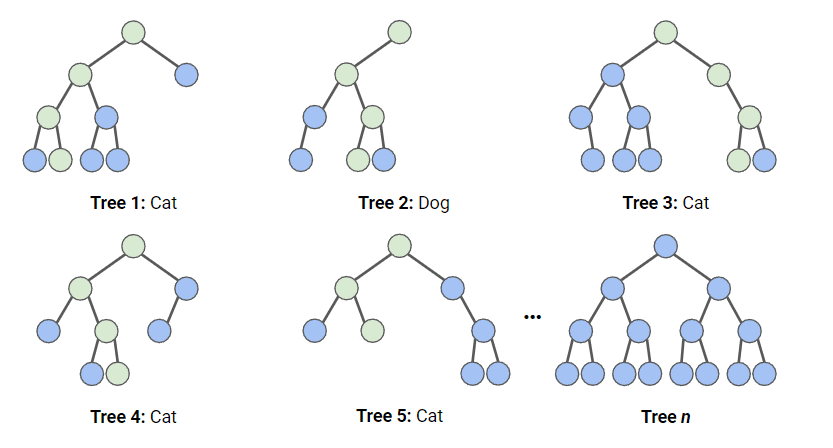

In [37]:
from IPython.display import Image
Image('/Users/julian/Documents/MIDS/W207/coursework_2022/final_project/amex-default-prediction/Randomforest.png', width=500)

#### Establish a baseline

In order to help judge the usefulness and generalization of our Random Forest model, we should establish a baseline. 
For the credit default scenario, our baseline will be to predict the most frequently recurring event of either no default or default. As such the baseline accuracy rate we hope our model will beat is the 1-error rate, where error rate is the baseline error we would get if we simply predicted no default for all.

In [38]:
#calculating the baselines accuracy rate to beat 
rate = 1-(Y_train.value_counts()[1]/Y_train.value_counts().sum())
print('Baseline Accuracy Rate: %.4f' %rate)

Baseline Accuracy Rate: 0.7560


`Building a random forest`

In [39]:
%%time
random_forest = RandomForestClassifier(criterion='entropy', #function to measure the quality of a feature split
                                n_estimators=10, #number of trees in the forest 
                                bootstrap = True, #different sample for each estimator
                                max_samples = 0.5, #max number of samples is 50% of training data
                                n_jobs=2) # The number of jobs to run in parallel.
clf = random_forest.fit(X_train, Y_train)

CPU times: user 5min 1s, sys: 4.36 s, total: 5min 5s
Wall time: 2min 36s


In [40]:
#lets set up some predictions based on our test dataset:
y_train_pred_tree = clf.predict(X_train)
y_val_pred_tree = clf.predict(X_val)

Accuracy on Training Data: 0.9609
Accuracy on Validation Data: 0.8712
Validation Precision score: 0.8342
Validation Recall score: 0.8211
Validation F1 score 0.8273


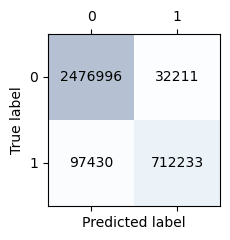

In [42]:
#lets look at the accuracy of our tree
print('Accuracy on Training Data: %.4f' %accuracy_score(Y_train,y_train_pred_tree))
print('Accuracy on Validation Data: %.4f' %accuracy_score(Y_val,y_val_pred_tree))
print('Validation Precision score: %.4f' % precision_score(Y_val,y_val_pred_tree, average='macro'))
print('Validation Recall score: %.4f' % recall_score(Y_val,y_val_pred_tree, average='macro'))
print('Validation F1 score %.4f' % f1_score(Y_val,y_val_pred_tree, average='macro'))

conf_matrix = confusion_matrix(Y_train,y_train_pred_tree) # confusion_matrix is available in sklearn.metrics
confusion_matrix_plot(conf_matrix)

Metrics on Validation Data:

In [43]:
# Get numerical feature importances
importances = list(random_forest.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_importances[:10]

[('P_2', 0.08039),
 ('D_48', 0.04113),
 ('D_45', 0.02905),
 ('B_8', 0.02529),
 ('B_6', 0.02452),
 ('D_75', 0.02394),
 ('B_2', 0.02183),
 ('B_3', 0.02103),
 ('B_33', 0.01993),
 ('B_38', 0.01614)]

Using the feature_importances attribute from SKlearn we can calculate the impurity-based feature importances. Above I am outputting the top 10 features

So far our data set looks to be performing quite well, with approx ~96% accuracy on our training data. While it is a good accuracy score, it was tested against the training data on which is was training so it is perhaps to be expected. As such there is some concern that overfitting has occured so we will try to attempt some hyperparameter tuning below. 

## Hyperparameter Tuning

Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with **each combination of values**. Randomized search on hyper parameters, unlike the regular gridsearchCV

In [44]:
#first lets look at all the parameters which we have available to tune
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.5,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

From looking at the available parameters there are several which stand out: 
* max_features which is the max number of features considered at each tree split. Since we didnt specify this when intiating our RF classifier, the default is SQRT. Which is approx 12/13. So this is something we can try tune
* max_depth which is how many levels of branches we have in our model. Wasnt specified earlier so then nodes are expanded until all leaves are pure or until
* Max_samples number of samples to draw from X, to train the estimators
* min_samples_split - decides the minimum number of samples required to split an internal node. Default value =2. issue with 2 is that the condition is checked on the terminal node. If the data points in the node exceed the value 2, then further splitting takes place. Whereas if a more lenient value like 6 is set, then the splitting will stop early and the decision tree wont overfit on the data.
* min_samples_leaf - If after a split the data points in a node goes under the min_sample_leaf number, the split won’t go through and will be stopped at the parent node.

From the above we can see that there are many parameters which we can try and tune using cross validation as well. 

Note: The parameters selected are those that maximize the score of the held-out data, according to the scoring parameter.

Refer to the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

According to the documentation, the grid which we want to create is a dictionary type

In [45]:
criterion = ['entropy'] #what will be used to choose features at node splits
n_estimators = [i for i in range(10,18,2)] # number of trees in the random forest
bootstrap = [True, False] # drawing samples from our source data with replacement
max_samples = [i/10 for i in range(2,8,2)] #percentage of training samples to train each tree with
n_jobs=[-1]
max_features = ['sqrt']  #could add in 'log2' but took too long
max_depth = [i for i in range(110,160,10)] #max amount of layers in a tree
max_depth.append(None)  #if None, then nodes are expanded until all leaves are pure
min_samples_split = [2, 6, 10] # minimum sample number to split a node, need at least two to split
min_samples_leaf = [1,2, 3] # A split point at any depth will only be considered if it leaves at least 
                             #min_samples_leaf training samples in each of the left and right branches.
                              #This may have the effect of smoothing the model, especially in regression

random_grid = { 'criterion' : criterion, 
               'n_estimators' : n_estimators, 
               'bootstrap' : bootstrap,
               'max_samples' : max_samples,
               'n_jobs' : n_jobs,
               'max_features' : max_features, 
               'max_depth' : max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf' : min_samples_leaf
              }

In [46]:
%%time
#first we need to initiate a new base tree estimator 
base_tree =  RandomForestClassifier()

#initialize the random search CV hyperparameter tuner
Random_Forest_HyperTuned = RandomizedSearchCV(estimator = base_tree,
                                              param_distributions = random_grid,
                                              n_iter = 10, #default
                                              cv = 3, #default is5-fold cross validation
                                              verbose = 1, #the higher, the more messages
                                              return_train_score = True # attribute will include training scores
                                             )
#now we need to train the model using our training data and labels
Random_Forest_HyperTuned.fit(X_train,Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/julian/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/julian/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julian/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 398, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.

  warnings.warn(some_fits_failed_me

CPU times: user 16min 16s, sys: 2min 10s, total: 18min 26s
Wall time: 16min 4s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy'],
                                        'max_depth': [110, 120, 130, 140, 150,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'max_samples': [0.2, 0.4, 0.6],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [10, 12, 14, 16],
                                        'n_jobs': [-1]},
                   return_train_score=True, verbose=1)

Now that we have ran the hyperparameter tuning, we can pull out the best supposed parameters used. 



In [47]:
Random_Forest_HyperTuned.best_params_

{'n_jobs': -1,
 'n_estimators': 16,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_samples': 0.6,
 'max_features': 'sqrt',
 'max_depth': 130,
 'criterion': 'entropy',
 'bootstrap': True}

These are the tuned parameters which our optimal Random Forest Model will have. So we can intiate a new model object with these tuned parameted and test it on our training data set. 

In [48]:
best_RF = Random_Forest_HyperTuned.best_estimator_

#generate predictions
y_pred_train = best_RF.predict(X_train)
y_pred_val = best_RF.predict(X_val)

Accuracy on Training Data: 0.9762
Accuracy on Validation Data: 0.8795
Validation Precision score: 0.8399
Validation Recall score: 0.8462
Validation F1 score 0.8430


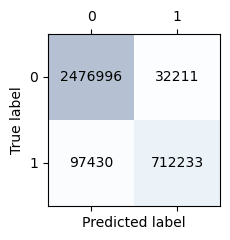

In [49]:
#lets look at the accuracy of our tree
print('Accuracy on Training Data: %.4f' %accuracy_score(Y_train,y_pred_train))
print('Accuracy on Validation Data: %.4f' %accuracy_score(Y_val,y_pred_val))
print('Validation Precision score: %.4f' % precision_score(Y_val,y_pred_val, average='macro'))
print('Validation Recall score: %.4f' % recall_score(Y_val,y_pred_val, average='macro'))
print('Validation F1 score %.4f' % f1_score(Y_val,y_pred_val, average='macro'))

confusion_matrix(Y_train,y_train_pred_tree) # confusion_matrix is available in sklearn.metrics
confusion_matrix_plot(conf_matrix)

Above we used the RandomizedSearchCV which in contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. 

Thus we can say the randomsearch gave us insight on values we can focus in on. With the gridsearch we will actually test all combination of the parameter dictionary, Grid search is used after randomised search to narrow down the range to search the perfect hyperparameters.

In [52]:
#given more computing power I would try more options below
random_grid_RandSearch = {'n_jobs': [-1],
               'n_estimators': [14,15,16],
               'min_samples_split': [2,3,4,5],
               'min_samples_leaf': [2,3,4,5],
               'max_samples': [0.4,0.5,0.6],
               'max_features': ['sqrt'],
               'max_depth': [125,130,135], #given more 
               'criterion': ['entropy'],
               'bootstrap': [True]}

In [ ]:
%%time
#first we need to initiate our final base tree estimator 
final_tree =  RandomForestClassifier()

#initialize our GridSearch object to finalize the hyperparameters
Final_Random_Forest = GridSearchCV(estimator = final_tree, 
                                   param_grid = random_grid_RandSearch,
                                   cv = 3, 
                                   n_jobs = -1, 
                                   verbose = 2
                                  )

#now we need to train the model using our training data and labels
Final_Random_Forest.fit(X_train,Y_train)

### Note: 
The above two cells (given my computing power) would not run. As such I will continue with the random forest hyperparameters according to the RandomizedSearchCV

## Performance Evaluation on Test Dataset

In [55]:
#generate predictions
y_pred_test = best_RF.predict(X_test)

Accuracy on Test Data: 0.8828
Validation Precision score: 0.8434
Validation Recall score: 0.8586
Validation F1 score 0.8505


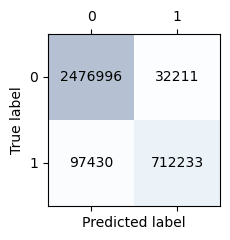

In [57]:
#lets look at the accuracy of our tree
print('Accuracy on Test Data: %.4f' %accuracy_score(Y_test,y_pred_test))
print('Validation Precision score: %.4f' % precision_score(Y_test,y_pred_test, average='macro'))
print('Validation Recall score: %.4f' % recall_score(Y_test,y_pred_test, average='macro'))
print('Validation F1 score %.4f' % f1_score(Y_test,y_pred_test, average='macro'))

confusion_matrix(Y_train,y_train_pred_tree) # confusion_matrix is available in sklearn.metrics
confusion_matrix_plot(conf_matrix)